## Figure for NeurIPS ML4PhysicalSciences submission

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import scipy.stats as st

quiet_event = 'G0H12-201804202100'
moderate_event = 'G2H12-201509071500'
storm_event = 'G4H12-202304231500'

models_path = '/mnt/double_a100_linnea_halil_backup/' 

lead_times = np.arange(1, 13, 1) * 60 # Every 60 minutes over 24 hours
print(lead_times)

def compute_rmse(ground_truth, prediction):
    """Compute the Root Mean Square Error between ground truth and prediction."""
    return np.sqrt(np.mean(np.power((ground_truth.flatten() - prediction.flatten()),2)))

def compute_lat_rmse(ground_truth, prediction):
    """Compute RMSE for low, mid, and high latitude bands.
    Accepts lat in either -90 to 90 or 0 to 180 (north to south).
    Returns a dict with keys 'low', 'mid', 'high'.
    """
    lat = np.arange(0, 180, 1)
    # If lat is 0-180, convert to -90 to 90 (assuming 0=north, 180=south)
    if np.all((lat >= 0) & (lat <= 180)):
        lat = 90 - lat
    # Indices for bands
    low_idx = np.where((lat >= -30) & (lat <= 30))[0]
    mid_idx = np.where(((lat >= -60) & (lat < -30)) | ((lat > 30) & (lat <= 60)))[0]
    high_idx = np.where(((lat >= -90) & (lat < -60)) | ((lat > 60) & (lat <= 90)))[0]

    def band_rmse(idx):
        if len(idx) == 0:
            return np.nan
        gt_band = ground_truth[:, idx, :].flatten()
        pred_band = prediction[:, idx, :].flatten()
        return np.sqrt(np.mean((gt_band - pred_band) ** 2))

    return {
        'low': band_rmse(low_idx),
        'mid': band_rmse(mid_idx),
        'high': band_rmse(high_idx)
    }

# Compute persistence RMSE for each event
def persistence_rmse(gt, lead_time):
    lead_time_idx = int(lead_time // 30)  # assuming 30 min per step

    pred = gt[:-lead_time_idx]
    target = gt[lead_time_idx:]

    global_rmse = compute_rmse(target, pred)
    lat_rmse = compute_lat_rmse(target, pred)

    return global_rmse, lat_rmse

[ 60 120 180 240 300 360 420 480 540 600 660 720]


In [17]:
##### Load long horizon data

# Load IRI data
quiet_iri_data_event = f'IRI/TEC_cube_{quiet_event[6:-4]}.npz'
moderate_iri_data_event = f'IRI/TEC_cube_{moderate_event[6:-4]}.npz'
severe_iri_data_event = f'IRI/TEC_cube_{storm_event[6:-4]}.npz'

IRI_quiet_data_long = np.load(models_path + quiet_iri_data_event)["tec_cube"][:, :180, :360]
IRI_moderate_data_long = np.load(models_path + moderate_iri_data_event)["tec_cube"][:, :180, :360]
# IRI_severe_data_long = np.load(models_path + severe_iri_data_event)["tec_cube"][:, :-1, :-1]

print(f'Loaded long horizon IRI data shapes: Quiet {IRI_quiet_data_long.shape}, Moderate {IRI_moderate_data_long.shape}') #, Severe {IRI_severe_data_long.shape}')

# Load JPLD data
quiet_JPLD_data_event = f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-long-horizon-event-{quiet_event}-original.npy'
moderate_JPLD_data_event = f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-long-horizon-event-{moderate_event}-original.npy'
severe_JPLD_data_event = f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-long-horizon-event-{storm_event}-original.npy'

JPLD_quiet_data_long = np.load(models_path + quiet_JPLD_data_event)
JPLD_moderate_data_long = np.load(models_path + moderate_JPLD_data_event)
JPLD_severe_data_long = np.load(models_path + severe_JPLD_data_event)

print(f'Loaded long horizon JPLD data shapes: Quiet {JPLD_quiet_data_long.shape}, Moderate {JPLD_moderate_data_long.shape}, Severe {JPLD_severe_data_long.shape}')

# Load LSTM data
quiet_LSTM_data_event = f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-long-horizon-event-{quiet_event}-forecast.npy'
moderate_LSTM_data_event = f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-long-horizon-event-{moderate_event}-forecast.npy'
severe_LSTM_data_event = f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-long-horizon-event-{storm_event}-forecast.npy'

LSTM_quiet_data_long = np.load(models_path + quiet_LSTM_data_event)
LSTM_moderate_data_long = np.load(models_path + moderate_LSTM_data_event)
LSTM_severe_data_long = np.load(models_path + severe_LSTM_data_event)

print(f'Loaded long horizon LSTM data shapes: Quiet {LSTM_quiet_data_long.shape}, Moderate {LSTM_moderate_data_long.shape}, Severe {LSTM_severe_data_long.shape}')

# Load GNN data
quiet_GNN_data_event = f'linnea_results/ioncastgnn-fulldataset-finalmodel_nov4/test-long-horizon-event-{quiet_event}-forecast.npy'
moderate_GNN_data_event = f'linnea_results/ioncastgnn-fulldataset-finalmodel_nov4/test-long-horizon-event-{moderate_event}-forecast.npy'
severe_GNN_data_event = f'linnea_results/ioncastgnn-fulldataset-finalmodel_nov4/test-long-horizon-event-{storm_event}-forecast.npy'

GNN_quiet_data_long = np.load(models_path + quiet_GNN_data_event)[:, 0, :, :]
GNN_moderate_data_long = np.load(models_path + moderate_GNN_data_event)[:, 0, :, :]
GNN_severe_data_long = np.load(models_path + severe_GNN_data_event)[:, 0, :, :]

print(f'Loaded long horizon GNN data shapes: Quiet {GNN_quiet_data_long.shape}, Moderate {GNN_moderate_data_long.shape}, Severe {GNN_severe_data_long.shape}')

# Get IRI vs. JPLD RMSE for long horizon
long_horizon_datasets = [
    ('IRI Quiet', IRI_quiet_data_long),
    ('JPLD Quiet', JPLD_quiet_data_long),
    ('LSTM Quiet', LSTM_quiet_data_long),
    ('GNN Quiet', GNN_quiet_data_long),
    ('IRI Moderate', IRI_moderate_data_long),
    ('JPLD Moderate', JPLD_moderate_data_long),
    ('LSTM Moderate', LSTM_moderate_data_long),
    ('GNN Moderate', GNN_moderate_data_long),
    # ('IRI Severe', IRI_severe_data_long),
    ('JPLD Severe', JPLD_severe_data_long),
    ('LSTM Severe', LSTM_severe_data_long),
    ('GNN Severe', GNN_severe_data_long),
]

for name, data in long_horizon_datasets:
    if 'Quiet' in name:
        gt = JPLD_quiet_data_long
    elif 'Moderate' in name:
        gt = JPLD_moderate_data_long
    elif 'Severe' in name:
        gt = JPLD_severe_data_long
    else:
        continue  # Should not happen

    global_rmse = compute_rmse(gt, data)
    lat_rmse = compute_lat_rmse(gt, data)
    
    print(f'Long horizon RMSE for {name}: {global_rmse:.2f} (low: {lat_rmse["low"]:.2f}, mid: {lat_rmse["mid"]:.2f}, high: {lat_rmse["high"]:.2f})')

# Load the ground data and the model lead time outputs
datasets_rmse = {}  # RMSE

for lead_time in lead_times:
    # Load JPLD reference data
    jpld_data_quiet_event = f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-fixed-lead-time-event-{quiet_event}-{lead_time}min-original.npy'
    jpld_data_moderate_event = f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-fixed-lead-time-event-{moderate_event}-{lead_time}min-original.npy'
    jpld_data_severe_event = f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-fixed-lead-time-event-{storm_event}-{lead_time}min-original.npy'

    quiet_jpld_data = np.load(models_path + jpld_data_quiet_event)
    moderate_jpld_data = np.load(models_path + jpld_data_moderate_event)
    severe_jpld_data = np.load(models_path + jpld_data_severe_event)

    print(f'Loaded JPLD data shapes: Quiet {quiet_jpld_data.shape}, Moderate {moderate_jpld_data.shape}, Severe {severe_jpld_data.shape}')

    # Load LSTM data
    quiet_LSTM_data_event = f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-fixed-lead-time-event-{quiet_event}-{lead_time}min-forecast.npy'
    moderate_LSTM_data_event = f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-fixed-lead-time-event-{moderate_event}-{lead_time}min-forecast.npy'
    severe_LSTM_data_event = f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-fixed-lead-time-event-{storm_event}-{lead_time}min-forecast.npy'

    LSTM_quiet_data = np.load(models_path + quiet_LSTM_data_event)
    LSTM_moderate_data = np.load(models_path + moderate_LSTM_data_event)
    LSTM_severe_data = np.load(models_path + severe_LSTM_data_event)

    print(f'Loaded LSTM data shapes: Quiet {LSTM_quiet_data.shape}, Moderate {LSTM_moderate_data.shape}, Severe {LSTM_severe_data.shape}')

    # Load GNN data
    quiet_GNN_data_event = f'linnea_results/ioncastgnn-fulldataset-finalmodel_nov4/test-fixed-lead-time-event-{quiet_event}-{lead_time}min-forecast.npy'
    moderate_GNN_data_event = f'linnea_results/ioncastgnn-fulldataset-finalmodel_nov4/test-fixed-lead-time-event-{moderate_event}-{lead_time}min-forecast.npy'
    severe_GNN_data_event = f'linnea_results/ioncastgnn-fulldataset-finalmodel_nov4/test-fixed-lead-time-event-{storm_event}-{lead_time}min-forecast.npy'

    GNN_quiet_data = np.load(models_path + quiet_GNN_data_event)
    GNN_moderate_data = np.load(models_path + moderate_GNN_data_event)
    GNN_severe_data = np.load(models_path + severe_GNN_data_event)

    print(f'Loaded GNN data shapes: Quiet {GNN_quiet_data.shape}, Moderate {GNN_moderate_data.shape}, Severe {GNN_severe_data.shape}')

    #compute RMSE for each model and event and print a table
    datasets = [
        ('JPLD Quiet', quiet_jpld_data),
        ('LSTM Quiet', LSTM_quiet_data),
        ('GNN Quiet', GNN_quiet_data),
        ('JPLD Moderate', moderate_jpld_data),
        ('LSTM Moderate', LSTM_moderate_data),
        ('GNN Moderate', GNN_moderate_data),
        ('JPLD Severe', severe_jpld_data),
        ('LSTM Severe', LSTM_severe_data),
        ('GNN Severe', GNN_severe_data),
    ]

    for name, data in datasets:
        if 'Quiet' in name:
            gt = quiet_jpld_data
        elif 'Moderate' in name:
            gt = moderate_jpld_data
        elif 'Severe' in name:
            gt = severe_jpld_data
        else:
            continue  # Should not happen

        global_rmse = compute_rmse(gt, data)
        lat_rmse = compute_lat_rmse(gt, data)
        
        if lead_time == lead_times[0]:
            datasets_rmse[name] = {'low': [], 'mid': [], 'high': [], 'global': []}

        datasets_rmse[name]['global'].append(global_rmse)
        datasets_rmse[name]['low'].append(lat_rmse['low'])
        datasets_rmse[name]['mid'].append(lat_rmse['mid'])
        datasets_rmse[name]['high'].append(lat_rmse['high'])
        print(f'RMSE for {name} and lead_time {lead_time}: {global_rmse:.2f} (low: {lat_rmse['low']:.2f}, mid: {lat_rmse['mid']:.2f}, high: {lat_rmse['high']:.2f})')

    # Add persistence RMSE for each event
    for event_name, gt in [('Quiet', quiet_jpld_data), ('Moderate', moderate_jpld_data), ('Severe', severe_jpld_data)]:
        key = f'Persistence {event_name}'
        if lead_time == lead_times[0]:
            datasets_rmse[key] = {'low': [], 'mid': [], 'high': [], 'global': []}
        global_rmse, lat_rmse = persistence_rmse(gt, lead_time)
        datasets_rmse[key]['global'].append(global_rmse)
        datasets_rmse[key]['low'].append(lat_rmse['low'])
        datasets_rmse[key]['mid'].append(lat_rmse['mid'])
        datasets_rmse[key]['high'].append(lat_rmse['high'])
        print(f'Persistence RMSE for {event_name} and lead_time {lead_time}: {global_rmse:.2f} (low: {lat_rmse['low']:.2f}, mid: {lat_rmse['mid']:.2f}, high: {lat_rmse['high']:.2f})')

print(datasets_rmse)
lat_size = quiet_jpld_data.shape[1]
lon_size = quiet_jpld_data.shape[2]
n_times = quiet_jpld_data.shape[0]

Loaded long horizon IRI data shapes: Quiet (48, 180, 360), Moderate (48, 180, 360)
Loaded long horizon JPLD data shapes: Quiet (48, 180, 360), Moderate (48, 180, 360), Severe (48, 180, 360)
Loaded long horizon LSTM data shapes: Quiet (48, 180, 360), Moderate (48, 180, 360), Severe (48, 180, 360)
Loaded long horizon GNN data shapes: Quiet (48, 180, 360), Moderate (48, 180, 360), Severe (48, 180, 360)
Long horizon RMSE for IRI Quiet: 5.32 (low: 8.33, mid: 3.15, high: 2.11)
Long horizon RMSE for JPLD Quiet: 0.00 (low: 0.00, mid: 0.00, high: 0.00)
Long horizon RMSE for LSTM Quiet: 8.26 (low: 11.81, mid: 5.53, high: 5.70)
Long horizon RMSE for GNN Quiet: 10.89 (low: 16.56, mid: 7.13, high: 5.17)
Long horizon RMSE for IRI Moderate: 6.24 (low: 8.80, mid: 5.09, high: 3.49)
Long horizon RMSE for JPLD Moderate: 0.00 (low: 0.00, mid: 0.00, high: 0.00)
Long horizon RMSE for LSTM Moderate: 11.50 (low: 16.66, mid: 6.98, high: 8.16)
Long horizon RMSE for GNN Moderate: 17.14 (low: 25.93, mid: 11.70, h

## scatter plot version

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import scipy.stats as st

# --------------------------------
# Setup
# --------------------------------
lon = np.linspace(-180, 180, 360)
lat = np.linspace(90, -90, 180)
event_level = "quiet"
# event_level = "moderate"
# event_level = "severe"
lead_time_to_plot = 1 # 0 - 11
lead_time_mins = lead_time_to_plot * 60
timestamp_to_plot = 40 # 0 - 48 #

quiet_event = 'G0H12-201804202100'
moderate_event = 'G2H12-201509071500'
storm_event = 'G4H12-202304231500'

models_path = '/mnt/double_a100_linnea_halil_backup/'

# Select data for the event and lead time
if event_level == "quiet":
    lstm_data = np.load(models_path + f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-fixed-lead-time-event-{quiet_event}-{lead_time_mins}min-forecast.npy')
    lstm_data_long = np.load(models_path + f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-long-horizon-event-{quiet_event}-forecast.npy')
    gnn_data = np.load(models_path + f'linnea_results/ioncastgnn-fulldataset-finalmodel_nov4/test-fixed-lead-time-event-{quiet_event}-{lead_time_mins}min-forecast.npy')
    gnn_data_long = np.load(models_path + f'linnea_results/ioncastgnn-fulldataset-finalmodel_nov4/test-long-horizon-event-{quiet_event}-forecast.npy')[:, 0, :, :]
    gt_data = np.load(models_path + f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-fixed-lead-time-event-{quiet_event}-{lead_time_mins}min-original.npy')
    gt_data_long = np.load(models_path + f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-long-horizon-event-{quiet_event}-original.npy')

    rmse_lstm = datasets_rmse['LSTM Quiet']
    rmse_gnn = datasets_rmse['GNN Quiet']
    rmse_persist = datasets_rmse['Persistence Quiet']

    title = "G0 - 2018-04-20"
    
elif event_level == "moderate":
    lstm_data = np.load(models_path + f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-fixed-lead-time-event-{moderate_event}-{lead_time_mins}min-forecast.npy')
    lstm_data_long = np.load(models_path + f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-long-horizon-event-{moderate_event}-forecast.npy')
    gnn_data = np.load(models_path + f'linnea_results/ioncastgnn-fulldataset-finalmodel_nov4/test-fixed-lead-time-event-{moderate_event}-{lead_time_mins}min-forecast.npy')
    gnn_data_long = np.load(models_path + f'linnea_results/ioncastgnn-fulldataset-finalmodel_nov4/test-long-horizon-event-{moderate_event}-forecast.npy')[:, 0, :, :]
    gt_data = np.load(models_path + f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-fixed-lead-time-event-{moderate_event}-{lead_time_mins}min-original.npy')
    gt_data_long = np.load(models_path + f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-long-horizon-event-{moderate_event}-original.npy')

    rmse_lstm = datasets_rmse['LSTM Moderate']
    rmse_gnn = datasets_rmse['GNN Moderate']
    rmse_persist = datasets_rmse['Persistence Moderate']

    title = "G2 - 2015-09-07"

elif event_level == "severe":
    lstm_data = np.load(models_path + f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-fixed-lead-time-event-{storm_event}-{lead_time_mins}min-forecast.npy')
    lstm_data_long = np.load(models_path + f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-long-horizon-event-{storm_event}-forecast.npy')
    gnn_data = np.load(models_path + f'linnea_results/ioncastgnn-fulldataset-finalmodel_nov4/test-fixed-lead-time-event-{storm_event}-{lead_time_mins}min-forecast.npy')
    gnn_data_long = np.load(models_path + f'linnea_results/ioncastgnn-fulldataset-finalmodel_nov4/test-long-horizon-event-{storm_event}-forecast.npy')[:, 0, :, :]
    gt_data = np.load(models_path + f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-fixed-lead-time-event-{storm_event}-{lead_time_mins}min-original.npy')
    gt_data_long = np.load(models_path + f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-long-horizon-event-{storm_event}-original.npy')

    rmse_lstm = datasets_rmse['LSTM Severe']
    rmse_gnn = datasets_rmse['GNN Severe']
    rmse_persist = datasets_rmse['Persistence Severe']

    title = "G4 - 2023-04-23"
else:
    raise ValueError('Unknown event_level')

# Other parameters
T, H, W = gt_data_long.shape
delta_minutes = 15

minutes_range = np.arange(1, T+1) * delta_minutes
hours_range = (minutes_range / 60).astype(int)
timestamps_unflattened = np.broadcast_to(hours_range[:, None, None] , (T, H, W))

n_pts = 360
step = 360 // n_pts
bins = 50
gridsize = 50
timestamps = timestamps_unflattened.flatten()

## Leadtime based hexbin plot version

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import scipy.stats as st

# --------------------------------
# Setup
# --------------------------------
lon = np.linspace(-180, 180, 360)
lat = np.linspace(90, -90, 180)
# event_level = "quiet"
event_level = "moderate"
# event_level = "severe"
lead_time_to_plot = 1 # 0 - 11
lead_time_mins = lead_time_to_plot * 60
timestamp_to_plot = 9 # 0 - 48 # 0 for quiet, 9 for moderate, 0 for severe
good_lstm_version = True

quiet_event = 'G0H12-201804202100'
moderate_event = 'G2H12-201509071500'
storm_event = 'G4H12-202304231500'

models_path = '/mnt/double_a100_linnea_halil_backup/'
event_ids = {"quiet": quiet_event, "moderate": moderate_event, "severe": storm_event}
title_ids = {"quiet": "G0 - 2018-04-20", "moderate": "G2 - 2015-09-07", "severe": "G4 - 2023-04-23"}
name_ids = {"quiet": "Quiet", "moderate": "Moderate", "severe": "Severe"}
 
# Select data for the event and lead time
lstm_data = []
gnn_data = []
gt_data = []

rmse_lstm = []
rmse_gnn = []
rmse_persist = []

for lead_time_mins in lead_times:
    if good_lstm_version:
        lstm_data.append(np.load(f'/mnt/ionosphere-experiments/neurips2025-ml4ps-submission/IonCastLSTM/test-fixed-lead-time-event-{event_ids[event_level]}-{lead_time_mins}min-forecast.npy'))
    else:
        lstm_data.append(np.load(models_path + f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-fixed-lead-time-event-{event_ids[event_level]}-{lead_time_mins}min-forecast.npy'))
    gnn_data.append(np.load(models_path + f'linnea_results/ioncastgnn-fulldataset-finalmodel_nov4/test-fixed-lead-time-event-{event_ids[event_level]}-{lead_time_mins}min-forecast.npy'))
    gt_data.append(np.load(models_path + f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-fixed-lead-time-event-{event_ids[event_level]}-{lead_time_mins}min-original.npy'))

lstm_data = np.stack(lstm_data) # [L, T, H, W]
gnn_data = np.stack(gnn_data)
gt_data = np.stack(gt_data)

rmse_lstm = datasets_rmse[f'LSTM {name_ids[event_level]}']
rmse_gnn = datasets_rmse[f'GNN {name_ids[event_level]}']
rmse_persist = datasets_rmse[f'Persistence {name_ids[event_level]}']

title = title_ids[event_level]

if good_lstm_version:
    lstm_data_long = np.load(f'/mnt/ionosphere-experiments/neurips2025-ml4ps-submission/IonCastLSTM/test-long-horizon-event-{event_ids[event_level]}-forecast.npy')
else:
    lstm_data_long = np.load(models_path + f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-long-horizon-event-{event_ids[event_level]}-forecast.npy')
gnn_data_long = np.load(models_path + f'linnea_results/ioncastgnn-fulldataset-finalmodel_nov4/test-long-horizon-event-{event_ids[event_level]}-forecast.npy')[:, 0, :, :]
gt_data_long = np.load(models_path + f'linnea_results/ioncastlstm-fulldataset-finalmodel-epoch75test/test-long-horizon-event-{event_ids[event_level]}-original.npy')

# Other parameters
L, T, H, W = gt_data.shape
delta_minutes = 15
minutes_range = lead_times #np.arange(1, L+1) * delta_minutes
hours_range = (minutes_range / 60).astype(int)
timestamps_unflattened = np.broadcast_to(hours_range[:, None, None, None] , (L, T, H, W))

n_pts = 360
step = 360 // n_pts
bins = 50
gridsize = 50
timestamps = timestamps_unflattened.flatten()
print(minutes_range)
print(hours_range)
print("Shapes:", lstm_data.shape, gnn_data.shape, gt_data.shape)
print("Long horizon shapes:", lstm_data_long.shape, gnn_data_long.shape, gt_data_long.shape)

[ 60 120 180 240 300 360 420 480 540 600 660 720]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
Shapes: (12, 49, 180, 360) (12, 49, 180, 360) (12, 49, 180, 360)
Long horizon shapes: (48, 180, 360) (48, 180, 360) (48, 180, 360)


In [34]:
# --- Function to build "jointplot" slot ---
def add_jointplot(fig, outer_spec, gt_s, pred_s, ts_s, gridsize=30, bins=40):
    sub_gs = gridspec.GridSpecFromSubplotSpec(
        2, 2, subplot_spec=outer_spec,
        width_ratios=[4, 1], height_ratios=[1, 4],
        wspace=0.05, hspace=0.05
    )
    ax_joint = fig.add_subplot(sub_gs[1, 0])
    ax_marg_x = fig.add_subplot(sub_gs[0, 0], sharex=ax_joint)
    ax_marg_y = fig.add_subplot(sub_gs[1, 1], sharey=ax_joint)

    # --- joint hexbin ---
    mode = lambda arr: st.mode(arr).mode
    im = ax_joint.hexbin(
        gt_s, pred_s,
        C=ts_s,
        reduce_C_function=mode,
        gridsize=gridsize, cmap='plasma',
        vmin=0, vmax=12
    )
    
    # Set colorbar ticks and labels up to 12
    ticks = np.arange(0, 13, 2)
    cbar = fig.colorbar(im, ax=ax_joint)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([str(t) for t in ticks])
    cbar.set_label("Timestamp (hr)")

    # --- marginals ---
    ax_marg_x.hist(gt_s, bins=bins, alpha=0.8, color='grey')
    ax_marg_y.hist(pred_s, bins=bins, orientation="horizontal", alpha=0.8, color='grey')

    # Remove all spines (borders) from marginal axes
    for spine in ax_marg_x.spines.values():
        spine.set_visible(False)
    for spine in ax_marg_y.spines.values():
        spine.set_visible(False)

    # Hide all ticks and labels on marginal axes only (not joint)
    ax_marg_x.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax_marg_y.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

    # --- decorations ---
    ax_joint.grid(True, alpha=0.3, linestyle="-", linewidth=0.5)

    vmin = min(float(np.min(gt_s)), float(np.min(pred_s)))
    vmax = max(float(np.max(gt_s)), float(np.max(pred_s)))

    # Set same ticks/labels for x and y axes
    ticks = np.arange(0, 200, 50).astype(int)
    ticklabels = [f"{int(tick)}" for tick in ticks]
    ax_joint.set_xticks(ticks)
    ax_joint.set_yticks(ticks)
    ax_joint.set_xticklabels(ticklabels)
    ax_joint.set_yticklabels(ticklabels)

    ax_joint.plot([vmin, vmax], [vmin, vmax], color="black",
                  linewidth=1.5, alpha=0.7, label="Perfect Prediction")
    

    corr = float(np.corrcoef(gt_s, pred_s)[0, 1])
    ax_joint.text(0.05, 0.90, f"R = {corr:.3f}",
                  transform=ax_joint.transAxes,
                  bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))
    return ax_joint, ax_marg_x, ax_marg_y


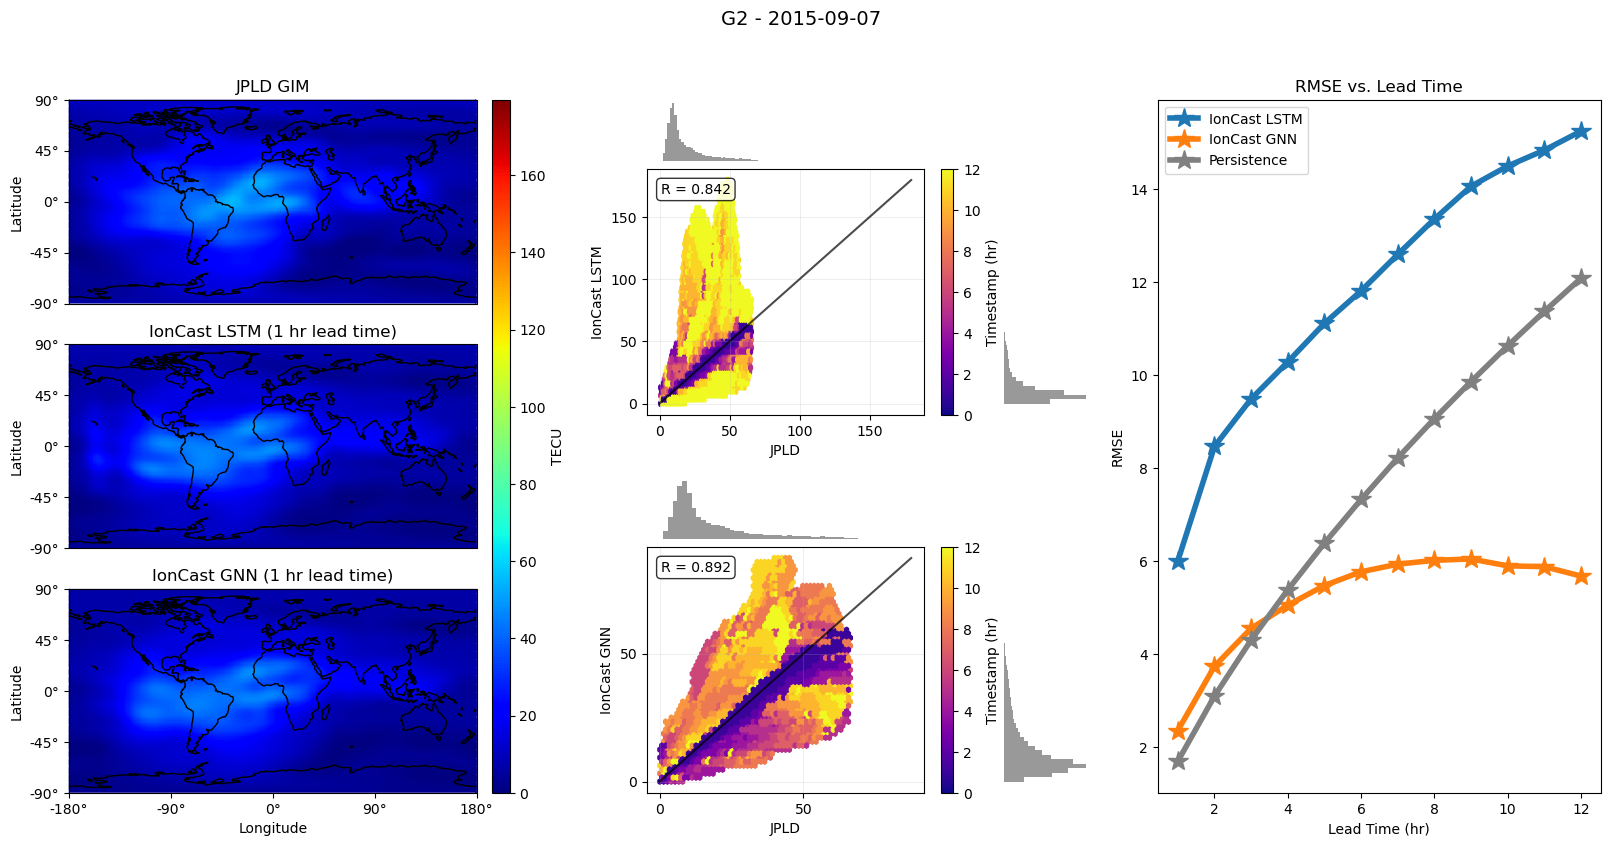

In [35]:
# --- Main 2x5 figure with custom jointplots in inner columns ---
fig = plt.figure(figsize=(20, 9))
gs = gridspec.GridSpec(3, 4, width_ratios=[1, 0.04, 1, 1])

# Map axes
ax_gt = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())  # Ground Truth
ax_lstm = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree())  # LSTM prediction
ax_gnn = fig.add_subplot(gs[2,0], projection=ccrs.PlateCarree())  # GNN prediction
cax_pred = fig.add_subplot(gs[:,1])  # full height column for colorbar
ax_rmse = fig.add_subplot(gs[:,3]) # RMSE plot

# Predictions
vmin = np.nanmin([lstm_data, gnn_data, gt_data])
vmax = np.nanmax([lstm_data, gnn_data, gt_data])

im_pred = []
im_pred.append(ax_gt.pcolormesh(lon, lat, gt_data[lead_time_to_plot][timestamp_to_plot],
                               cmap='jet', vmin=vmin, vmax=vmax, shading='auto'))
ax_gt.set_title(f'JPLD GIM')
ax_gt.coastlines()

im_pred.append(ax_lstm.pcolormesh(lon, lat, lstm_data[lead_time_to_plot][timestamp_to_plot],
                               cmap='jet', vmin=vmin, vmax=vmax, shading='auto'))
ax_lstm.set_title(f'IonCast LSTM ({int(lead_time_to_plot)} hr lead time)')
ax_lstm.coastlines()

im_pred.append(ax_gnn.pcolormesh(lon, lat, gnn_data[lead_time_to_plot][timestamp_to_plot],
                               cmap='jet', vmin=vmin, vmax=vmax, shading='auto'))
ax_gnn.set_title(f'IonCast GNN ({int(lead_time_to_plot)} hr lead time)')
ax_gnn.coastlines()

# Add colorbar in its own gridspec column, label on the side
cbar_pred = fig.colorbar(im_pred[0], cax=cax_pred, orientation='vertical')
cbar_pred.set_label('TECU', loc='center')

# Move prediction colorbar left
pos_cpred = cax_pred.get_position()
cax_pred.set_position([pos_cpred.x0-0.035, pos_cpred.y0, pos_cpred.width, pos_cpred.height])

# Set ticks and labels for all map axes in column 1 (outer edges)
for ax, is_bottom, is_left in zip([ax_gt, ax_lstm, ax_gnn], [False, False, True], [True, True, True]):
    # Y axis ticks for all
    ax.set_yticks([-90, -45, 0, 45, 90])
    ax.set_yticklabels(['-90°', '-45°', '0°', '45°', '90°'])
    if is_left:
        ax.set_ylabel('Latitude')
    # X axis ticks only for bottom plot
    if is_bottom:
        ax.set_xticks([-180, -90, 0, 90, 180])
        ax.set_xticklabels(['-180°', '-90°', '0°', '90°', '180°'])
        ax.set_xlabel('Longitude')
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])

# Hexbin plots
# Carve column 2 into 2 vertical regions
col_split = gridspec.GridSpecFromSubplotSpec(
    2, 1, subplot_spec=gs[:, 2], height_ratios=[1,1]
)

gt_s = gt_data.flatten()

# Jointplot for LSTM (no timestamps)
pred_s = lstm_data.flatten()

ax_lstm_hex, _, _ = add_jointplot(fig, col_split[0], gt_s, pred_s, ts_s=timestamps, gridsize=gridsize, bins=bins)
ax_lstm_hex.set_xlabel('JPLD')
ax_lstm_hex.set_ylabel('IonCast LSTM')

# Jointplot for GNN (with timestamps)
pred_s = gnn_data.flatten()

ax_gnn_hex, _, _ = add_jointplot(fig, col_split[1], gt_s, pred_s, ts_s=timestamps, gridsize=gridsize, bins=bins)
ax_gnn_hex.set_xlabel('JPLD')
ax_gnn_hex.set_ylabel('IonCast GNN')

# Move col_split to the left
# col_split.set_position([col_split.x0-0.025, col_split.y0, col_split.width, col_split.height])

# RMSE line plot (reuse from previous cell)
lead_time_hrs = (np.array(lead_times) / 60).astype(int)

# Set gray legend

ax_rmse.plot(lead_time_hrs, rmse_lstm['global'], marker='*', ms=15, lw=4, c='tab:blue', label='IonCast LSTM')
ax_rmse.plot(lead_time_hrs, rmse_gnn['global'], marker='*', ms=15, lw=4, c='tab:orange', label='IonCast GNN')
ax_rmse.plot(lead_time_hrs, rmse_persist['global'], marker='*', ms=15, lw=4, c='gray', label='Persistence')

# Plot RMSE latitude ranges
# ax_rmse.plot(lead_time_hrs, rmse_lstm['low'], marker='o', ms=5, lw=2, linestyle='dashed', c='tab:blue')
# ax_rmse.plot(lead_time_hrs, rmse_gnn['low'], marker='o', ms=5, lw=2, linestyle='dashed', c='tab:orange')
# # ax_rmse.plot(lead_time_hrs, rmse_persist['low'], marker='o', lw=2, linestyle='dashed', c='gray')

# ax_rmse.plot(lead_time_hrs, rmse_lstm['mid'], marker='o', ms=5, lw=2, linestyle='dotted', c='tab:blue')
# ax_rmse.plot(lead_time_hrs, rmse_gnn['mid'], marker='o', ms=5, lw=2, linestyle='dotted', c='tab:orange')
# # ax_rmse.plot(lead_time_hrs, rmse_persist['mid'], marker='o', lw=2, linestyle='dotted', c='gray')

# ax_rmse.plot(lead_time_hrs, rmse_lstm['high'], marker='o', ms=5, lw=2, linestyle='dashdot', c='tab:blue')
# ax_rmse.plot(lead_time_hrs, rmse_gnn['high'], marker='o', ms=5, lw=2, linestyle='dashdot', c='tab:orange')
# ax_rmse.plot(lead_time_hrs, rmse_persist['high'], marker='o', lw=2, linestyle='dashdot', c='gray')

ax_rmse.set_title('RMSE vs. Lead Time')
ax_rmse.set_xlabel('Lead Time (hr)')
ax_rmse.set_ylabel('RMSE')
ax_rmse.legend()

# Move RMSE plot left
pos_rmse = ax_rmse.get_position()
ax_rmse.set_position([pos_rmse.x0, pos_rmse.y0, pos_rmse.width, pos_rmse.height])

plt.suptitle(title, fontsize=14)

plt.savefig(f"/home/LinneaWolniewicz/2025-HL-Ionosphere/results/final_neurips_paper_nov14/results_figure_jointhex_{event_level}_global_comparable_lstm_{good_lstm_version}.png", dpi=100)
plt.show()

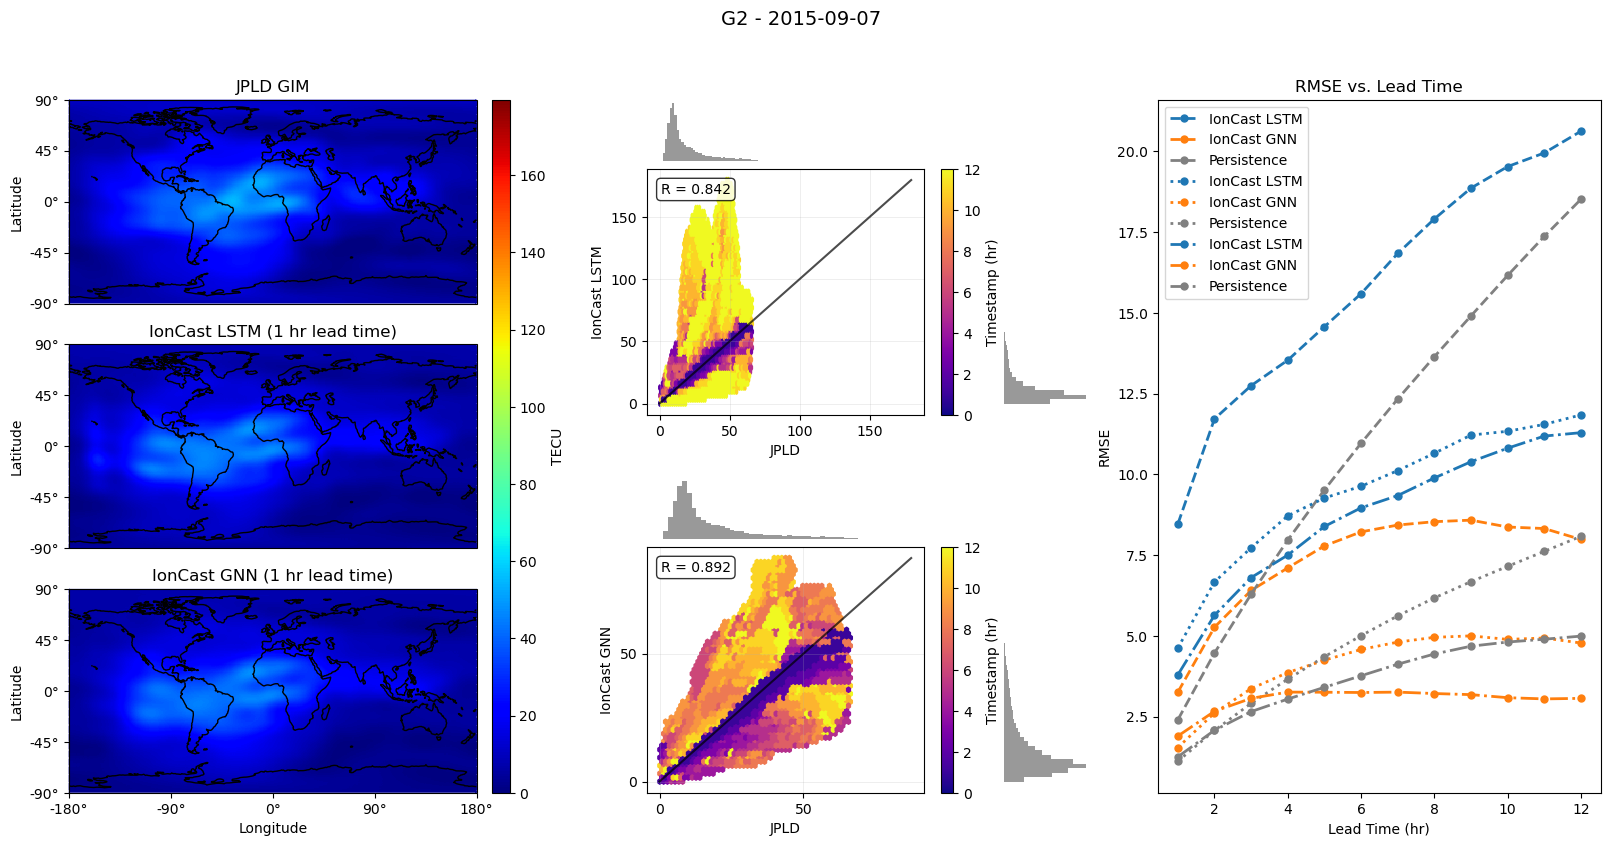

In [37]:
# --- Main 2x5 figure with custom jointplots in inner columns ---
fig = plt.figure(figsize=(20, 9))
gs = gridspec.GridSpec(3, 4, width_ratios=[1, 0.04, 1, 1])

# Map axes
ax_gt = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())  # Ground Truth
ax_lstm = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree())  # LSTM prediction
ax_gnn = fig.add_subplot(gs[2,0], projection=ccrs.PlateCarree())  # GNN prediction
cax_pred = fig.add_subplot(gs[:,1])  # full height column for colorbar
ax_rmse = fig.add_subplot(gs[:,3]) # RMSE plot

# Predictions
vmin = np.nanmin([lstm_data, gnn_data, gt_data])
vmax = np.nanmax([lstm_data, gnn_data, gt_data])

im_pred = []
im_pred.append(ax_gt.pcolormesh(lon, lat, gt_data[lead_time_to_plot][timestamp_to_plot],
                               cmap='jet', vmin=vmin, vmax=vmax, shading='auto'))
ax_gt.set_title(f'JPLD GIM')
ax_gt.coastlines()

im_pred.append(ax_lstm.pcolormesh(lon, lat, lstm_data[lead_time_to_plot][timestamp_to_plot],
                               cmap='jet', vmin=vmin, vmax=vmax, shading='auto'))
ax_lstm.set_title(f'IonCast LSTM ({int(lead_time_to_plot)} hr lead time)')
ax_lstm.coastlines()

im_pred.append(ax_gnn.pcolormesh(lon, lat, gnn_data[lead_time_to_plot][timestamp_to_plot],
                               cmap='jet', vmin=vmin, vmax=vmax, shading='auto'))
ax_gnn.set_title(f'IonCast GNN ({int(lead_time_to_plot)} hr lead time)')
ax_gnn.coastlines()

# Add colorbar in its own gridspec column, label on the side
cbar_pred = fig.colorbar(im_pred[0], cax=cax_pred, orientation='vertical')
cbar_pred.set_label('TECU', loc='center')

# Move prediction colorbar left
pos_cpred = cax_pred.get_position()
cax_pred.set_position([pos_cpred.x0-0.035, pos_cpred.y0, pos_cpred.width, pos_cpred.height])

# Set ticks and labels for all map axes in column 1 (outer edges)
for ax, is_bottom, is_left in zip([ax_gt, ax_lstm, ax_gnn], [False, False, True], [True, True, True]):
    # Y axis ticks for all
    ax.set_yticks([-90, -45, 0, 45, 90])
    ax.set_yticklabels(['-90°', '-45°', '0°', '45°', '90°'])
    if is_left:
        ax.set_ylabel('Latitude')
    # X axis ticks only for bottom plot
    if is_bottom:
        ax.set_xticks([-180, -90, 0, 90, 180])
        ax.set_xticklabels(['-180°', '-90°', '0°', '90°', '180°'])
        ax.set_xlabel('Longitude')
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])

# Hexbin plots
# Carve column 2 into 2 vertical regions
col_split = gridspec.GridSpecFromSubplotSpec(
    2, 1, subplot_spec=gs[:, 2], height_ratios=[1,1]
)

gt_s = gt_data.flatten()

# Jointplot for LSTM (no timestamps)
pred_s = lstm_data.flatten()

ax_lstm_hex, _, _ = add_jointplot(fig, col_split[0], gt_s, pred_s, ts_s=timestamps, gridsize=gridsize, bins=bins)
ax_lstm_hex.set_xlabel('JPLD')
ax_lstm_hex.set_ylabel('IonCast LSTM')

# Jointplot for GNN (with timestamps)
pred_s = gnn_data.flatten()

ax_gnn_hex, _, _ = add_jointplot(fig, col_split[1], gt_s, pred_s, ts_s=timestamps, gridsize=gridsize, bins=bins)
ax_gnn_hex.set_xlabel('JPLD')
ax_gnn_hex.set_ylabel('IonCast GNN')

# Move col_split to the left
# col_split.set_position([col_split.x0-0.025, col_split.y0, col_split.width, col_split.height])

# RMSE line plot (reuse from previous cell)
lead_time_hrs = (np.array(lead_times) / 60).astype(int)

# ax_rmse.plot(lead_time_hrs, rmse_lstm['global'], marker='*', ms=15, lw=4, c='tab:blue', label='IonCast LSTM')
# ax_rmse.plot(lead_time_hrs, rmse_gnn['global'], marker='*', ms=15, lw=4, c='tab:orange', label='IonCast GNN')
# ax_rmse.plot(lead_time_hrs, rmse_persist['global'], marker='*', ms=15, lw=4, c='gray', label='Persistence')

# Plot RMSE latitude ranges
ax_rmse.plot(lead_time_hrs, rmse_lstm['low'], marker='o', ms=5, lw=2, linestyle='dashed', c='tab:blue', label='IonCast LSTM')
ax_rmse.plot(lead_time_hrs, rmse_gnn['low'], marker='o', ms=5, lw=2, linestyle='dashed', c='tab:orange', label='IonCast GNN')
ax_rmse.plot(lead_time_hrs, rmse_persist['low'], marker='o', ms=5, lw=2, linestyle='dashed', c='gray', label='Persistence')

ax_rmse.plot(lead_time_hrs, rmse_lstm['mid'], marker='o', ms=5, lw=2, linestyle='dotted', c='tab:blue', label='IonCast LSTM')
ax_rmse.plot(lead_time_hrs, rmse_gnn['mid'], marker='o', ms=5, lw=2, linestyle='dotted', c='tab:orange', label='IonCast GNN')
ax_rmse.plot(lead_time_hrs, rmse_persist['mid'], marker='o', ms=5, lw=2, linestyle='dotted', c='gray', label='Persistence')

ax_rmse.plot(lead_time_hrs, rmse_lstm['high'], marker='o', ms=5, lw=2, linestyle='dashdot', c='tab:blue', label='IonCast LSTM')
ax_rmse.plot(lead_time_hrs, rmse_gnn['high'], marker='o', ms=5, lw=2, linestyle='dashdot', c='tab:orange', label='IonCast GNN')
ax_rmse.plot(lead_time_hrs, rmse_persist['high'], marker='o', ms=5, lw=2, linestyle='dashdot', c='gray', label='Persistence')

ax_rmse.set_title('RMSE vs. Lead Time')
ax_rmse.set_xlabel('Lead Time (hr)')
ax_rmse.set_ylabel('RMSE')
ax_rmse.legend()

# Move RMSE plot left
pos_rmse = ax_rmse.get_position()
ax_rmse.set_position([pos_rmse.x0, pos_rmse.y0, pos_rmse.width, pos_rmse.height])

plt.suptitle(title, fontsize=14)

plt.savefig(f"/home/LinneaWolniewicz/2025-HL-Ionosphere/results/final_neurips_paper_nov14/results_figure_jointhex_{event_level}_latitudesplit_comparable_lstm_{good_lstm_version}.png", dpi=100)
plt.show()